In [1]:
print('hello')

hello


In [2]:
! pip install nltk


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# worldcloud
import random
from wordcloud import WordCloud


In [4]:
# Download NLTK resources (only needed once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\33668\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\33668\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\33668\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
# retrieving the datasets we used for the last notebook

raw_path = '../data/olist_datasets/'

df_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
df_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
df_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
df_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
df_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
df_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
df_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')


# I - Sentiment analysis of customer reviews

## A - Reminders on the Review dataframe

In [6]:
# checking that df_order_reviews is loaded

df_order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


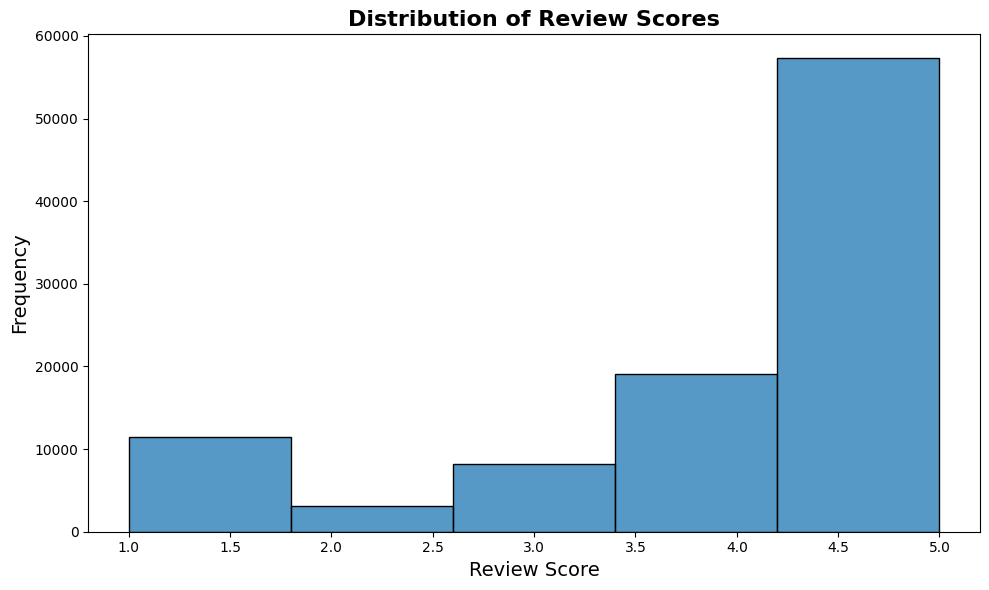

In [7]:
# Create a distribution plot (dist plot) with seaborn on the review score

# "professional" colors
colors = ['#2C3E50', '#E74C3C', '#ECF0F1', '#3498DB', '#2ECC71', '#F1C40F', '#9B59B6']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create histogram with seaborn
ax = sns.histplot(data=df_order_reviews, 
            x='review_score',
            bins=5,
            edgecolor='black',
            stat='count')

# Customizing the plot
plt.title('Distribution of Review Scores', fontsize=16, fontweight='bold')
plt.xlabel('Review Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Ajuster les marges
plt.tight_layout()

# Show the plot
plt.show();


In [13]:
# Check for missing values in review comments
print("Missing values in review comments:")
print(df_order_reviews[['review_comment_title', 'review_comment_message']].isnull().sum())


# Filter out rows with missing comments
reviews_with_comments = df_order_reviews.dropna(subset=['review_comment_message'])
print(f"\nTotal reviews: {len(df_order_reviews)}")
print(f"Reviews with comments: {len(reviews_with_comments)}")


Missing values in review comments:
review_comment_title      87656
review_comment_message    58247
dtype: int64

Total reviews: 99224
Reviews with comments: 40977


In [16]:
# Create a new column to categorize reviews as positive, neutral, or negative
def categorize_sentiment(score):
    '''if score is >=4 then good, if <3 then bad, else neutral'''
    if score >= 4:
        return 'positive'
    elif score < 3:
        return 'negative'
    else:
        return 'neutral'

# apply the function to the dataframe
df_order_reviews['sentiment'] = df_order_reviews['review_score'].apply(categorize_sentiment)


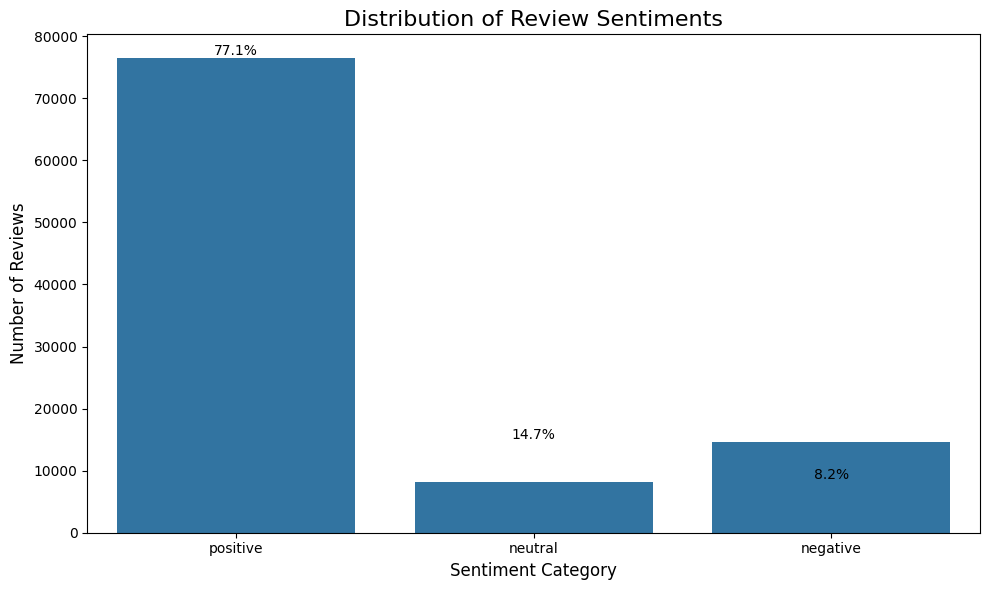

In [18]:
# Visualize the sentiment distribution - how many reviews by categories?
plt.figure(figsize=(10, 6))
sns.countplot(data=df_order_reviews, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Distribution of Review Sentiments', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Add percentage labels
total = len(df_order_reviews)
for index, value in enumerate(df_order_reviews['sentiment'].value_counts()):
    plt.text(index, value, f'{(value/total)*100:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


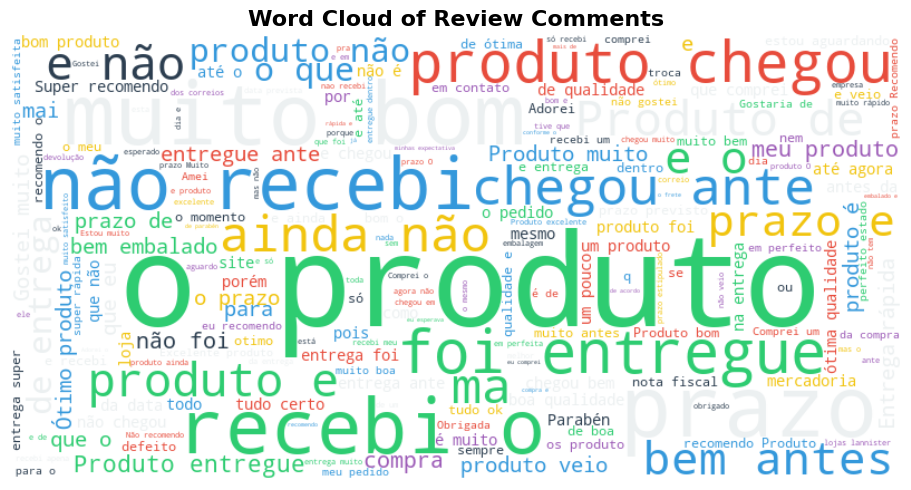

In [19]:
## Wordcloud

# Create a wordcloud on orders with negative reviews only

# Define a color function
def color_func(word, font_size, position, orientation, random_state=42, **kwargs):
    return random.choice(colors)

# Example: Word cloud from review comments
plt.figure(figsize=(10, 5))

# every order
# wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(' '.join(df['review_comment_message'].dropna()))

# only negative reviews
#reviews_with_negative_comments = reviews_with_comments[reviews_with_comments.review_score < 3]
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func)
wordcloud.generate(' '.join(reviews_with_comments['review_comment_message'].dropna()))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Review Comments', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


## B - Text Preprocessing and conversion to numerical features

### 1 - Cleaning a small sample of the data and looking at the results

In [22]:
# create a new sample dataframe, that will be a sample of df_order_reviews
# which only have non null review_comment_messages
# which only contains review_id, review_score, review_comment_message

sample_df = df_order_reviews[['review_id', 'review_score', 'review_comment_message']].dropna(subset=['review_comment_message'])

                           review_id  review_score  \
3   e64fb393e7b32834bb789ff8bb30750e             5   
4   f7c4243c7fe1938f181bec41a392bdeb             5   
9   8670d52e15e00043ae7de4c01cc2fe06             4   
12  4b49719c8a200003f700d3d986ea1a19             4   
15  3948b09f7c818e2d86c9a546758b2335             5   

                               review_comment_message  
3               Recebi bem antes do prazo estipulado.  
4   Parabéns lojas lannister adorei comprar pela I...  
9   aparelho eficiente. no site a marca do aparelh...  
12    Mas um pouco ,travando...pelo valor ta Boa.\r\n  
15  Vendedor confiável, produto ok e entrega antes...  


In [24]:
# create a new comment_clean column which makes the text LOWER (no uppercases)

sample_df['comment_clean'] = sample_df['review_comment_message'].str.lower()
sample_df


,review_id,review_score,review_comment_message,comment_clean
3,e64fb393e7b32834bb789ff8bb30750e,5,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar pela i...
9,8670d52e15e00043ae7de4c01cc2fe06,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente. no site a marca do aparelh...
12,4b49719c8a200003f700d3d986ea1a19,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","mas um pouco ,travando...pelo valor ta boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,"Vendedor confiável, produto ok e entrega antes...","vendedor confiável, produto ok e entrega antes..."
...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,4,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a compr...
99208,df5fae90e85354241d5d64a8955b2b09,5,Entregou dentro do prazo. O produto chegou em ...,entregou dentro do prazo. o produto chegou em ...
99215,a709d176f59bc3af77f4149c96bae357,3,"O produto não foi enviado com NF, não existe v...","o produto não foi enviado com nf, não existe v..."
99221,b3de70c89b1510c4cd3d0649fd302472,5,"Excelente mochila, entrega super rápida. Super...","excelente mochila, entrega super rápida. super..."


In [26]:
# remove the special characters using a simple regex function

sample_df['comment_clean'] = sample_df['comment_clean'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x)))
sample_df

,review_id,review_score,review_comment_message,comment_clean
3,e64fb393e7b32834bb789ff8bb30750e,5,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado
4,f7c4243c7fe1938f181bec41a392bdeb,5,Parabéns lojas lannister adorei comprar pela I...,parabns lojas lannister adorei comprar pela in...
9,8670d52e15e00043ae7de4c01cc2fe06,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente no site a marca do aparelho...
12,4b49719c8a200003f700d3d986ea1a19,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mas um pouco travandopelo valor ta boa\r\n
15,3948b09f7c818e2d86c9a546758b2335,5,"Vendedor confiável, produto ok e entrega antes...",vendedor confivel produto ok e entrega antes d...
...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,4,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a compr...
99208,df5fae90e85354241d5d64a8955b2b09,5,Entregou dentro do prazo. O produto chegou em ...,entregou dentro do prazo o produto chegou em c...
99215,a709d176f59bc3af77f4149c96bae357,3,"O produto não foi enviado com NF, não existe v...",o produto no foi enviado com nf no existe vend...
99221,b3de70c89b1510c4cd3d0649fd302472,5,"Excelente mochila, entrega super rápida. Super...",excelente mochila entrega super rpida super re...


In [27]:
# tokenize the text - meaning, isolate all words into a list, using the NLTK library, and another column - comment_clean_tokenized

sample_df['comment_clean_tokenized'] = sample_df['comment_clean'].apply(lambda x: word_tokenize(x))
sample_df
    

NameError: name 'word_tokenize' is not defined

In [ ]:
# then remove the stopwords using the portuguese library from NLTK

'your code'


In [ ]:
# Use stemming to shorten the words as much as possible using another column - comment_clean_stemmed

stemmer = PorterStemmer()

'your code'


### 2 - Text preprocessing

In [ ]:
# Define a function to clean and preprocess text
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        'your code'
        
        # Remove special characters, numbers, and punctuation
        'your code'
        
        # Tokenize the text
        'your code'
        
        # Remove stopwords (Portuguese)
        'your code'
        
        # Stemming
        'your code'
        
        # Join tokens back into a string
        'your code'
        
        return 'your code'
    else:
        return ''  # Return empty string for non-string inputs


In [ ]:
# Apply preprocessing to the review comments

'your code'


In [ ]:
# Display a sample of original and processed comments

'your code'


### 3 - Final preparation steps

In [ ]:
# Split the data into training and testing sets

'your code'


## C - Building a Simple Naive Bayes Model

In [ ]:
# Use CountVectorizer to convert text to a matrix of token counts
count_vectorizer = CountVectorizer(max_features=5000)  # Limit to top 5000 features

'your code'

print(f"Shape of training features: {X_train_counts.shape}")
print(f"Shape of testing features: {X_test_counts.shape}")


In [ ]:
# understanding what we just did

# Some computation to find an interesting extract to look at
word_freq = X_train_counts.sum(axis=0).A1  # converting the matrix into an A1 array
word_indices = word_freq.argsort()[-10:][::-1]  # 10 most frequent words
top_feature_names = [count_vectorizer.get_feature_names_out()[i] for i in word_indices]

# creating a sample with 10 most frequent words + 5 first reviews
df_sample = pd.DataFrame(
    X_train_counts[:5, word_indices].toarray(),
    columns=top_feature_names
)

print("Displaying an extract of the bag-of-words matrix (5 first comments, 10 most frequent words):")
df_sample

In [ ]:
# Train a Naive Bayes classifier
nb_classifier = MultinomialNB()

'your code'


In [ ]:
# Make predictions on the test set

'your code'


In [ ]:
# Evaluate the model

'your code'


In [ ]:
# Display classification report
print("Classification Report:\n")

'your code'


In [ ]:
# Create and display confusion matrix

'your code'


## D - Building a More Advanced Model - Logistic Regression with TF-IDF

In [ ]:
# Use TF-IDF Vectorizer for better feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

'your code'


In [ ]:
# Train a Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)

'your code'


In [ ]:
# Make predictions on the test set

'your code'

# Evaluate the model

'your code'


In [ ]:
# Display classification report

'your code'


In [ ]:
# Create and display confusion matrix

'your code'

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_classifier.classes_, 
            yticklabels=lr_classifier.classes_)
plt.title('Confusion Matrix - Logistic Regression', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show();


In [ ]:
# Get feature importance from Logistic Regression model
feature_importance = pd.DataFrame({
    'feature': tfidf_vectorizer.get_feature_names_out(),
    'importance': lr_classifier.coef_.mean(axis=0)
})

# Sort by absolute importance
feature_importance['abs_importance'] = abs(feature_importance['importance'])
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)


In [ ]:
# Display most important positive and negative words
print("Top 10 words associated with positive sentiment:")
positive_features = feature_importance.sort_values('importance', ascending=False).head(10)
print(positive_features[['feature', 'importance']])

print("\nTop 10 words associated with negative sentiment:")
negative_features = feature_importance.sort_values('importance', ascending=True).head(10)
print(negative_features[['feature', 'importance']])


In [ ]:
# Visualize top features
plt.figure(figsize=(12, 8))

top_features = pd.concat([positive_features.head(15), negative_features.head(15)])

colors = ['green' if x > 0 else 'red' for x in top_features['importance']]

'your code'

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show();


## E - Rainforest model

In [ ]:
# Start a timer to understand how long the model will last
start_time = time.time()

# Create a random forest model, while limiting the number of trees to make sure it doesn't run for too long
rf_classifier = RandomForestClassifier(
    n_estimators=100,     # number of trees in the forest
    max_depth=None,       # trees can be as deep (long) as possible
    min_samples_split=2,  # minimum split number to build a node (2 trees min to build a node)
    random_state=42,
    n_jobs=-1             # use all possible resources
)

# Use the model on the X_train TF-IDF data (same than the logistic regression)
'your code'

# Predictions on the train set
'your code'

# Compute execution time
training_time = time.time() - start_time
print(f"Random Forest training: {training_time:.2f} seconds")


In [ ]:
# Evaluate the model

'your code'



In [ ]:
# Display the classification report

'your code'


In [ ]:
# Create and display the confusion matrix

'your code'


In [ ]:
# get the feature importance of the Random Forest model

'your code'


In [ ]:
# Visualize the most important features

'your code'


## F - Model comparison

In [ ]:

# Compare the performances of the 2 models
models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']
accuracies = [accuracy_nb, accuracy_lr, accuracy_rf]

'your code'


In [ ]:
# Compute the F1 score by class (f1_nb, f1_lr, f1_rf)

'your code'

# Create a dataframe for the visualization
f1_df = pd.DataFrame({
    'Naive Bayes': f1_nb,
    'Logistic Regression': f1_lr,
    'Random Forest': f1_rf
}, index=rf_classifier.classes_)

# Visualize F1 scores by classes

'your code'

## G - Example use case: predicting new comments

In [ ]:
# Create a function to predict sentiment for new reviews
def predict_sentiment(review_text, vectorizer, model):
    # Preprocess the review
    processed_review = preprocess_text(review_text)
    # Vectorize the review
    review_vector = vectorizer.transform([processed_review])
    # Predict the sentiment
    sentiment = model.predict(review_vector)[0]
    # Get prediction probabilities
    proba = model.predict_proba(review_vector)[0]
    # Return the sentiment and confidence
    return sentiment, proba


In [ ]:
# Example reviews to test
example_reviews = [
    "O produto é excelente, superou minhas expectativas!",  # Positive
    "Entrega foi feita no prazo, mas o produto não é tão bom quanto esperava.",  # Neutral
    "Péssimo produto, chegou com defeito e o atendimento ao cliente foi horrível."  # Negative
]

# Predict sentiment for example reviews
print("Predicting sentiment for example reviews:")
for i, review in enumerate(example_reviews):
    'your code here'
    print(f"\nExample {i+1}: {review}")
    print(f"Predicted sentiment: {sentiment}")
    print(f"Confidence: {max(proba):.2f}")
    print(f"Probabilities: {dict(zip(lr_classifier.classes_, proba))}")
    

# II - Delivery prediction (bonus)

## A - Data preparation

In [ ]:
# We'll use the merged dataframe from previous parts
# If not already done, we need to merge the necessary dataframes
if 'df' not in globals():
    # Load required datasets
    df_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
    df_customers = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
    df_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
    df_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
    
    # Merge datasets
    df = df_orders.merge(df_customers, on='customer_id')
    df = df.merge(df_order_items, on='order_id')
    df = df.merge(df_products, on='product_id')

df.head()


In [ ]:
# Convert date columns to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    df[col] = pd.to_datetime(df[col])


# Calculate delivery time in days
df['actual_delivery_time'] = (df['order_delivered_customer_date'] - 
                             df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# Calculate if the delivery was delayed (1) or not (0)
df['estimated_delivery_time'] = (df['order_estimated_delivery_date'] - 
                                df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)
df['is_delayed'] = (df['actual_delivery_time'] > df['estimated_delivery_time']).astype(int)

# Calculate time to carrier in days
df['time_to_carrier'] = (df['order_delivered_carrier_date'] - 
                        df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# Filter out rows with missing delivery dates (canceled orders, etc.)
delivery_df = df.dropna(subset=['order_delivered_customer_date', 'order_delivered_carrier_date'])

delivery_df.head()


In [ ]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='is_delayed', data=delivery_df, palette='viridis')
plt.title('Distribution of Delayed vs On-time Deliveries', fontsize=16)
plt.xlabel('Is Delayed (1 = Yes, 0 = No)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['On-time', 'Delayed'])
for i, count in enumerate(delivery_df['is_delayed'].value_counts()):
    plt.text(i, count + 100, f"{count} ({count/len(delivery_df):.1%})", 
             ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## B - Feature Engineering

In [ ]:

model_df = delivery_df.copy()

# Extract temporal features
model_df['purchase_hour'] = model_df['order_purchase_timestamp'].dt.hour
model_df['purchase_day'] = model_df['order_purchase_timestamp'].dt.day
model_df['purchase_month'] = model_df['order_purchase_timestamp'].dt.month
model_df['purchase_year'] = model_df['order_purchase_timestamp'].dt.year
model_df['purchase_dayofweek'] = model_df['order_purchase_timestamp'].dt.dayofweek
model_df['purchase_weekend'] = (model_df['purchase_dayofweek'] >= 5).astype(int)

# Calculate distance between customer and seller (using zip code prefix as a proxy)
model_df['zip_distance'] = abs(model_df['customer_zip_code_prefix'] - model_df['seller_zip_code_prefix'])

# Calculate price per weight
model_df['price_per_weight'] = model_df['price'] / model_df['product_weight_g'].replace(0, 0.1)

# Create product volume feature
model_df['product_volume'] = (model_df['product_length_cm'] * 
                             model_df['product_height_cm'] * 
                             model_df['product_width_cm'])

# Handle infinite values
model_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the first few rows of the engineered features
print("Sample of engineered features:")
model_df[['purchase_hour', 'purchase_day', 'purchase_month', 'purchase_year', 
                'purchase_dayofweek', 'purchase_weekend', 'zip_distance', 
                'price_per_weight', 'product_volume']].head()

## C - Exploratory Data Analysis for Feature Selection

In [ ]:
# Analyze correlation between features and delivery time with a correlation matrix

'your code here'


In [ ]:
# Analyze categorical features
categorical_features = ['customer_state', 'seller_state', 'product_category_name']

# compute the average delivery time for each of the categorical feature with a bar chart

'your code here'


## D - Feature Selection

In [ ]:
# Select features based on correlation analysis and domain knowledge
selected_numeric_features = ['freight_value', 'price', 'product_weight_g', 
                            'product_volume', 'zip_distance', 'time_to_carrier',
                            'purchase_month', 'purchase_dayofweek']


In [ ]:
# Prepare feature and target variables
X_numeric = model_df[selected_numeric_features]
X_categorical = model_df[selected_categorical_features]
X_combined = pd.concat([X_numeric, X_categorical], axis=1)

# For regression task (predicting delivery time)
y_regression = model_df['actual_delivery_time']

# Split the data
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X_combined, y_regression, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

## E - Building the Regression Model (Predicting Delivery Time)

In [ ]:
# Define preprocessing for numeric features

'your code here'


In [ ]:
# Create a Linear Regression Pipeline

'your code here'

# Train and evaluate Linear Regression

'your code here'


In [ ]:
# Make predictions based on your linear regression

'your code here'

# Evaluate the model
mae_lr = 'your code here'
rmse_lr = 'your code here'
r2_lr = 'your code here'

print(f"Linear Regression - MAE: {mae_lr:.2f} days")
print(f"Linear Regression - RMSE: {rmse_lr:.2f} days")
print(f"Linear Regression - R²: {r2_lr:.2f}")


the R² should be about 0.40, which is not a good number. Can you do better with a Random Forest model, or any other model? 

Objective is to get a R² > 0.45!

## F - Building a Random Forest model

In [ ]:
'your code here'

### G - Building a K-Nearest Neighbors model

In [ ]:
'your code here'